In [7]:
!conda install shapely descartes pytables geopandas lightgbm -y

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.12
  latest version: 4.6.14

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.



In [9]:
!conda install -c conda-forge tqdm -y

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.12
  latest version: 4.6.14

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/ec2-user/anaconda3/envs/python3

  added / updated specs: 
    - tqdm


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    tqdm-4.31.1                |             py_0          40 KB  conda-forge

The following NEW packages will be INSTALLED:

    tqdm:            4.31.1-py_0       conda-forge

The following packages will be UPDATED:

    ca-certificates: 2019.1.23-0                   --> 2019.3.9-hecc5488_0 conda-forge
    certifi:         2019.3.9-py36_0               --> 2019.3.9-py36_0     conda-forge
    openssl:         1.0.2r-h7b6447c_0             --> 1.0.2r-h14c3975_0   conda-forge


tqdm-4.31.1          | 40 KB     | #######

In [1]:
import pandas as pd
from shapely.geometry import Point
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import seaborn as sns
import numpy as np
import warnings
import math
import re

tqdm.pandas()

plt.style.use('seaborn')

warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

%run ../src/utils.py

In [2]:
train = pd.read_csv('../data/raw/data_train.zip', index_col='Unnamed: 0', low_memory=True)
train.shape

(814262, 11)

In [3]:
test = pd.read_csv('../data/raw/data_test.zip', index_col='Unnamed: 0', low_memory=True)
test.shape

(202937, 11)

In [4]:
data = pd.concat([train, test], axis=0)
data.shape

(1017199, 11)

# Timing
Time-related features

In [5]:
data['minute_entry'] = data.time_exit.progress_apply(lambda x: int(x.split(':')[1]))
data['minute_exit'] = data.time_exit.progress_apply(lambda x: int(x.split(':')[1]))

data['hour_entry'] = data.time_entry.progress_apply(lambda x: int(x.split(':')[0]))
data['hour_exit'] = data.time_exit.progress_apply(lambda x: int(x.split(':')[0]))

data['time_entry'] = pd.to_timedelta(data.time_entry)
data['time_exit'] = pd.to_timedelta(data.time_exit)

In [6]:
data['time_entry'] = pd.to_timedelta(data.time_entry)
data['time_exit'] = pd.to_timedelta(data.time_exit)

data['deltat_min'] = (data.time_exit - data.time_entry) / np.timedelta64(1, 'm')

# Distance Evaluation
Euclidian, Minkowski, Haversine distances.

In [7]:
def euclidian_distance(x_one, y_one, x_two, y_two):
    return np.sqrt(np.power((x_one-x_two), 2) + np.power((y_one-y_two), 2))

def minkowski_distance(x_one, y_one, x_two, y_two):
    return abs(x_one-x_two) + abs(y_one-y_two)

data['euclidian_distance'] = np.sqrt(np.power(data.x_entry.values-data.x_exit.values, 2)+np.power(data.y_entry.values-data.y_exit.values, 2))

data['minkowski_distance'] = np.abs(data.x_entry.values-data.x_exit.values) + np.abs(data.y_entry.values-data.y_exit.values)

In [8]:
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

data['harvesine_distance'] = [haversine(x1, y1, x2, y2) for x1, y1, x2, y2 in zip(data.x_entry, data.y_entry,
                                                                                data.x_exit, data.y_exit)]

In [9]:
data = data[data.euclidian_distance!=0]
data.shape

(491966, 19)

### Quadrants

In [10]:
x_center = center['x_min'] + ((center['x_max']-center['x_min'])/2)
y_center = center['y_min'] + ((center['y_max']+center['y_min'])/2)

In [11]:
def quadrant(x, y, which):
    if which == 'third':
        if center['x_min'] <= x <= x_center and center['y_min'] <= y <= y_center:
            return 1
        else:
            return 0
        
    elif which == 'first':
        if center['x_min'] <= x <= x_center and center['y_max'] >= y >= y_center:
            return 1
        else:
            return 0
        
    elif which == 'fourth':
        if center['x_max'] >= x >= x_center and center['y_min'] >= y >= y_center:
            return 1
        else:
            return 0
    elif which == 'second':
        if center['x_max'] >= x >= x_center and center['y_min'] <= y <= y_center:
            return 1
        else:
            return 0
    else:
        return 0
        

data['first_quadrant_entry'] = [quadrant(x, y, which='first') for x, y in zip(data.x_entry, data.y_entry)]
data['third_quadrant_entry'] = [quadrant(x, y, which='third') for x, y in zip(data.x_entry, data.y_entry)]
data['fourth_quadrant_entry'] = [quadrant(x, y, which='fourth') for x, y in zip(data.x_entry, data.y_entry)]
data['second_quadrant_entry'] = [quadrant(x, y, which='second') for x, y in zip(data.x_entry, data.y_entry)]

### Distances to Center Middle Point

In [12]:
data['distance_cc_entry'] = np.sqrt(((data.x_entry.values-x_center)**2) + ((data.y_entry.values-y_center)**2))
data['distance_cc_exit'] = np.sqrt(((data.x_exit.values-x_center)**2) + ((data.y_exit.values-y_center)**2))

data['diff_cc_exit_entry'] = data.distance_cc_exit - data.distance_cc_entry

In [13]:
data['x_diff_entry'] = data.x_entry.values-x_center
data['x_diff_exit'] = data.x_exit.values-x_center

data['y_diff_entry'] = data.y_entry.values-y_center
data['y_diff_exit'] = data.y_exit.values-y_center

In [14]:
directions_entry = []
for x, y in zip(data.x_diff_entry, data.y_diff_entry):
    directions_entry.append(math.atan2(x, y))
    
data['direction_entry'] = directions_entry

In [15]:
directions_exit = []
for x, y in zip(data.x_diff_exit, data.y_diff_exit):
    directions_exit.append(math.atan2(x, y))
    
data['direction_exit'] = directions_exit

### Distances from Center Borders
Euclidian distance from point to city center borders.

In [16]:
from shapely.geometry import Point, Polygon, LineString

center['left_border']  = LineString([(center['x_min'], center['y_min']), (center['x_min'], center['y_max'])])
center['right_border'] = LineString([(center['x_max'], center['y_min']), (center['x_max'], center['y_max'])])

center['lower_border']  = LineString([(center['x_min'], center['y_min']), (center['x_max'], center['y_min'])])
center['upper_border']  = LineString([(center['x_min'], center['y_max']), (center['x_max'], center['y_max'])])

center['left_border'].distance(Point(center['x_max'], center['y_min']))

20000.0

In [17]:
def distance_to_border(x, y, direction):
    return center[direction + '_border'].distance(Point(x, y))

data['distance_left_border'] = [distance_to_border(x, y, direction='left') for x, y in zip(data.x_entry, data.y_entry)]
data['distance_right_border'] = [distance_to_border(x, y, direction='right') for x, y in zip(data.x_entry, data.y_entry)]
data['distance_lower_border'] = [distance_to_border(x, y, direction='lower') for x, y in zip(data.x_entry, data.y_entry)]
data['distance_upper_border'] = [distance_to_border(x, y, direction='upper') for x, y in zip(data.x_entry, data.y_entry)]

# Angles w.r.t Center
Mid and vertex-related angles on a per point basis

In [18]:
data['last_x_entry'] = data.groupby('hash').x_exit.shift(1)
data['last_y_entry'] = data.groupby('hash').y_exit.shift(1)

angle_cols = [
    'cc_middle_angle', 'cc_xmin_ymin_angle', 'cc_xmax_ymin_angle', 'cc_xmin_ymax_angle', 'cc_xmax_ymax_angle'
]

data = data.reindex(columns=data.columns.tolist() + angle_cols)

data = data.progress_apply(entry_to_center_angles, axis=1)

data = data.drop(columns=['last_x_entry', 'last_y_entry'])

data.head(4)

,hash,trajectory_id,time_entry,time_exit,vmax,vmin,vmean,x_entry,y_entry,x_exit,...,direction_exit,distance_left_border,distance_right_border,distance_lower_border,distance_upper_border,cc_middle_angle,cc_xmin_ymin_angle,cc_xmax_ymin_angle,cc_xmin_ymax_angle,cc_xmax_ymax_angle
0,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_0,07:04:31,07:08:32,NaN,NaN,NaN,3.751014e+06,-1.909398e+07,3.750326e+06,...,-0.000546,114925.024135,116633.059928,174924.969304,114924.969304,NaN,NaN,NaN,NaN,NaN
1,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_1,07:20:34,07:25:42,NaN,NaN,NaN,3.743937e+06,-1.932247e+07,3.744975e+06,...,-0.000830,54012.799354,59966.283785,54012.799354,113775.281047,0.137059,0.038653,0.188293,0.042244,0.310604
2,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_2,07:53:32,08:03:25,NaN,NaN,NaN,3.744868e+06,-1.929356e+07,3.744816e+06,...,-0.000837,25386.747582,35858.533322,25386.747582,84874.048910,0.198812,0.120334,0.476339,0.057555,0.234039
3,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_3,08:17:50,08:37:23,NaN,NaN,NaN,3.744880e+06,-1.929229e+07,3.744809e+06,...,-0.000837,24146.972686,34984.767305,24146.972686,83601.282594,0.173281,0.132425,0.711798,0.044184,0.184758


In [19]:
data[angle_cols] = data[angle_cols] * 180.0 / np.pi
data.head(4)

,hash,trajectory_id,time_entry,time_exit,vmax,vmin,vmean,x_entry,y_entry,x_exit,...,direction_exit,distance_left_border,distance_right_border,distance_lower_border,distance_upper_border,cc_middle_angle,cc_xmin_ymin_angle,cc_xmax_ymin_angle,cc_xmin_ymax_angle,cc_xmax_ymax_angle
0,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_0,07:04:31,07:08:32,NaN,NaN,NaN,3.751014e+06,-1.909398e+07,3.750326e+06,...,-0.000546,114925.024135,116633.059928,174924.969304,114924.969304,NaN,NaN,NaN,NaN,NaN
1,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_1,07:20:34,07:25:42,NaN,NaN,NaN,3.743937e+06,-1.932247e+07,3.744975e+06,...,-0.000830,54012.799354,59966.283785,54012.799354,113775.281047,7.852886,2.214659,10.788397,2.420383,17.796301
2,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_2,07:53:32,08:03:25,NaN,NaN,NaN,3.744868e+06,-1.929356e+07,3.744816e+06,...,-0.000837,25386.747582,35858.533322,25386.747582,84874.048910,11.391105,6.894649,27.292186,3.297664,13.409474
3,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_3,08:17:50,08:37:23,NaN,NaN,NaN,3.744880e+06,-1.929229e+07,3.744809e+06,...,-0.000837,24146.972686,34984.767305,24146.972686,83601.282594,9.928271,7.587407,40.782997,2.531528,10.585844


# Target feature

In [20]:
def is_inside_city(x, y):
    if (3750901.5068 <= x <= 3770901.5068) and (-19268905.6133 <= y <= -19208905.6133):
        return 1
    else:
        return 0

data['is_inside_city_entry'] = [is_inside_city(x, y) for x, y in zip(data.x_entry, data.y_entry)]
data['is_inside_city_exit'] = [is_inside_city(x, y) for x, y in zip(data.x_exit, data.y_exit)]

In [25]:
# time passed between blind spots

data['time_delta_blind'] = (data.time_entry - data.time_exit.shift(1)) / np.timedelta64(1, 'm')

In [26]:
# time passed between blind spots

data['x_delta_blind'] = data.x_entry - data.x_exit.shift(1)
data['y_delta_blind'] = data.y_entry - data.y_exit.shift(1)

data['distance_blind'] = ((data.x_delta_blind**2) + (data.y_delta_blind)**2)**(1/2)

data.loc[data.time_delta_blind < 0, 'distance_blind'] = 0

data.loc[data.time_delta_blind < 0, 'x_delta_blind'] = 0
data.loc[data.time_delta_blind < 0, 'y_delta_blind'] = 0
data.loc[data.time_delta_blind < 0, 'time_delta_blind'] = 0

data.head(4)

,hash,trajectory_id,time_entry,time_exit,vmax,vmin,vmean,x_entry,y_entry,x_exit,...,cc_xmax_ymin_angle,cc_xmin_ymax_angle,cc_xmax_ymax_angle,is_inside_city_entry,is_inside_city_exit,center_permanency,x_delta_blind,y_delta_blind,distance_blind,time_delta_blind
0,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_0,07:04:31,07:08:32,NaN,NaN,NaN,3.751014e+06,-1.909398e+07,3.750326e+06,...,NaN,NaN,NaN,0,0,0.0,NaN,NaN,NaN,NaN
1,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_1,07:20:34,07:25:42,NaN,NaN,NaN,3.743937e+06,-1.932247e+07,3.744975e+06,...,10.788397,2.420383,17.796301,0,0,0.0,-6388.625577,-186127.626359,186237.235350,12.033333
2,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_2,07:53:32,08:03:25,NaN,NaN,NaN,3.744868e+06,-1.929356e+07,3.744816e+06,...,27.292186,3.297664,13.409474,0,0,0.0,-106.866711,26098.775095,26098.993888,27.833333
3,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_3,08:17:50,08:37:23,NaN,NaN,NaN,3.744880e+06,-1.929229e+07,3.744809e+06,...,40.782997,2.531528,10.585844,0,0,0.0,64.565305,551.388913,555.156205,14.416667


In [27]:
data['trajectory_number'] = data.trajectory_id.progress_apply(lambda x: int(re.findall('_\d+$', x)[0].strip('_')))

data.loc[data.trajectory_number==0, 'distance_blind'] = 0
data.loc[data.trajectory_number==0, 'time_delta_blind'] = 0

# Time: Continuous features

In [28]:
data['hours_continuous'] = [t / pd.Timedelta(hours=1) for t in data.time_entry]
data['minutes_continuous'] = [t / pd.Timedelta(minutes=1) for t in data.time_entry]

# Trajectories' Origin Point Features

It is a logical estimate that an extensive group in all recorded trajectories will eventually return to their origin point in the day - relating, in this case, to a person's return home. Dealing with paths distributed in space and time, the current-point to origin-point correlation levels hold a considerable chance to be proportional to any either spatial coordinates, time, or both.

With that in mind, let us then compute features focused on current-to-origin point differences.

In [29]:
origin_data = data.groupby('hash').nth(0).select_dtypes([np.number])
origin_data.columns = [f'origin_{c}' for c in origin_data.columns.ravel()]
origin_data = origin_data.reset_index()

last_data = data.groupby('hash').shift(1).select_dtypes([np.number])
last_data.columns = [f'last_{c}' for c in last_data.columns.ravel()]
last_data['hash'] = data['hash']

In [30]:
for d, prefix in zip([last_data, origin_data], ['last', 'origin']):
    if data.columns.contains(f'{prefix}_time'):
        data = data[data.columns.drop(d.columns)]
    
    data = data.merge(d, on='hash')

In [31]:
for p in ['last', 'origin']:
    # Generic deltas
    for idx in ['vmin', 'vmax', 'vmean', 'center_permanency', 'x_diff_entry', 'y_diff_entry', 'direction_entry']:
        data[f'delta_{p}_{idx}'] = data[idx] - data[f'{p}_{idx}']

    # Time-related deltas
    data[f'deltat_{p}_entry'] = (data.time_entry - data[f'{p}_time_entry']) / pd.Timedelta(minutes=1)
    data[f'deltat_{p}_exit'] = (data.time_entry - data[f'{p}_time_exit']) / pd.Timedelta(minutes=1)

    data[f'delta_{p}_hr_entry'] = data.hours_continuous - data[f'{p}_hours_continuous']
    data[f'delta_{p}_min_entry'] = data.minutes_continuous - data[f'{p}_minutes_continuous']

    # Distance-related deltas
    data[f'deltad_{p}_entry'] = euclidian_distance(data[f'{p}_x_entry'], data[f'{p}_y_entry'], data.x_entry, data.y_entry)
    data[f'deltad_{p}_exit'] = euclidian_distance(data[f'{p}_x_exit'], data[f'{p}_y_exit'], data.x_entry, data.y_entry)

    for side in ['left', 'right', 'lower', 'upper']:
        data[f'deltad_{p}_{side}_border'] = data[f'distance_{side}_border'] - data[f'{p}_distance_{side}_border']

    data[f'deltad_{p}_cc'] = data.distance_cc_entry - data[f'{p}_distance_cc_entry']

    # Angle-related deltas
    for vertex in ['xmin_ymin', 'xmax_ymin', 'xmin_ymax', 'xmax_ymax', 'middle']:
        data[f'delta^_{p}_{vertex}'] = data[f'cc_{vertex}_angle'] - data[f'{p}_cc_{vertex}_angle']

    data = data[data.columns.drop([x for x in data.columns.ravel() if x.startswith(f'{p}_time_')])]

data.head(5)

,hash,trajectory_id,time_entry,time_exit,vmax,vmin,vmean,x_entry,y_entry,x_exit,...,deltad_origin_left_border,deltad_origin_right_border,deltad_origin_lower_border,deltad_origin_upper_border,deltad_origin_cc,delta^_origin_xmin_ymin,delta^_origin_xmax_ymin,delta^_origin_xmin_ymax,delta^_origin_xmax_ymax,delta^_origin_middle
0,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_0,07:04:31,07:08:32,NaN,NaN,NaN,3.751014e+06,-1.909398e+07,3.750326e+06,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
1,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_0,07:04:31,07:08:32,NaN,NaN,NaN,3.751014e+06,-1.909398e+07,3.750326e+06,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_0,07:04:31,07:08:32,NaN,NaN,NaN,3.751014e+06,-1.909398e+07,3.750326e+06,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
3,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_0,07:04:31,07:08:32,NaN,NaN,NaN,3.751014e+06,-1.909398e+07,3.750326e+06,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
4,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_0,07:04:31,07:08:32,NaN,NaN,NaN,3.751014e+06,-1.909398e+07,3.750326e+06,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN


### Aggregating features

In [32]:
window_reference = 5

cols_to_agg = ['vmax', 'vmin', 'vmean', 'x_entry', 'y_entry', 'minute_entry', 'hours_continuous', 'minutes_continuous',
               'hour_entry', 'first_quadrant_entry', 'third_quadrant_entry', 'fourth_quadrant_entry', 'second_quadrant_entry',
               'trajectory_number', 'distance_cc_entry', 'deltat_min', 'x_diff_entry', 'y_diff_entry', 'direction_entry',
               'distance_left_border', 'distance_right_border', 'distance_lower_border', 'distance_upper_border'] + angle_cols

agg_features = (data.groupby(['hash', 'time_entry', 'trajectory_id'])[cols_to_agg]
                .mean()
                .shift(1)
                .rolling(window_reference, min_periods=1)
                .agg(['mean', 'max', 'std', 'min', 'sum']))

agg_features.columns = ["_".join(x) for x in agg_features.columns.ravel()]
data = data.merge(agg_features.reset_index(), 
                    on=['hash', 'trajectory_id', 'time_entry'])
data.head(4)

MemoryError: 

# Sequence Data

In [ ]:
window_reference = 5

grouped = data.groupby(['hash']).tail(window_reference)
grouped['sequence'] = np.ones(grouped.shape[0])
df = grouped.groupby(by=['hash','time_entry', 'trajectory_id']).sum().groupby(level=[0]).cumsum().reset_index()[['trajectory_id', 'sequence']]
df.columns = ['trajectory_id', 'trajectory_sequence']
grouped = grouped.merge(df, on='trajectory_id', how='left')

In [ ]:
hash_count_trajectories = grouped.groupby(['hash']).trajectory_id.count().reset_index()
hash_count_trajectories.columns = ['hash', 'count_trajectories']

grouped = grouped.merge(hash_count_trajectories, on='hash', how='left')
grouped.head(4)

In [ ]:
ref = window_reference
for i in range(1, window_reference):
    grouped.loc[grouped.count_trajectories==i, 'trajectory_sequence'] += ref-1
    ref -= 1
    
grouped.head(4)

In [ ]:
grouped = grouped.drop('sequence', axis=1)
#grouped['traje']

In [ ]:
data_sequence = grouped.groupby(['hash', 'trajectory_sequence']).mean().unstack()
data_sequence.shape

In [ ]:
data_sequence.columns = ['_'.join([x[0], str(int(x[1]))]) for x in data_sequence.columns.ravel()]
data_sequence.head(3)

In [ ]:
data_sequence = data_sequence.reset_index()

In [ ]:
data_sequence.shape

In [ ]:
data_train = data_sequence[data_sequence['hour_exit_'+str(window_reference)]==15]
data_train.shape

In [ ]:
hashs_train = list(train.hash.unique())
hashs_test = list(test.hash.unique())

data_train = data_train[data_train.hash.isin(hashs_train)]
data_train.shape

In [ ]:
drop_cols = list(x for x in data.columns if 'exit' in x) + grid_cols
drop_cols += ['euclidian_distance', 'minkowski_distance', 'harvesine_distance',
              'center_permanency', 'has_crossed_city', 'velocity']
drop_cols += [f'origin_{col}' for col in drop_cols]
drop_cols += [f'delta_{col}' for col in drop_cols if col.startswith('origin_')]
drop_cols += ['delta_last_center_permanency']

drop_cols = [f'{col}_{window_reference}' for col in drop_cols]
drop_cols += [f'{col}_i' for col in grid_cols for i in range(0, 5)]
drop_cols += ['hash']

features = list(set(data_train.columns) - set(drop_cols))
target   = ['is_inside_city_exit_'+str(window_reference)]

In [ ]:
from sklearn.model_selection import train_test_split


dt_train, dt_test = train_test_split(data_train, test_size=0.2, random_state=20)
dt_train.shape, dt_test.shape

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score

clf = LGBMClassifier(n_estimators=150, max_features=0.5, seed=20)
clf.fit(dt_train[features], dt_train[target])

predicted = clf.predict(dt_test[features])

f1_score(dt_test[target], predicted)

In [465]:
# Score 0.7465277777777779 | 0.89441
# Score 0.7432216905901117 | 0.89358
# Score 0.7413765697027499 | 0.89307 - n_estimators=150, max_features=0.5

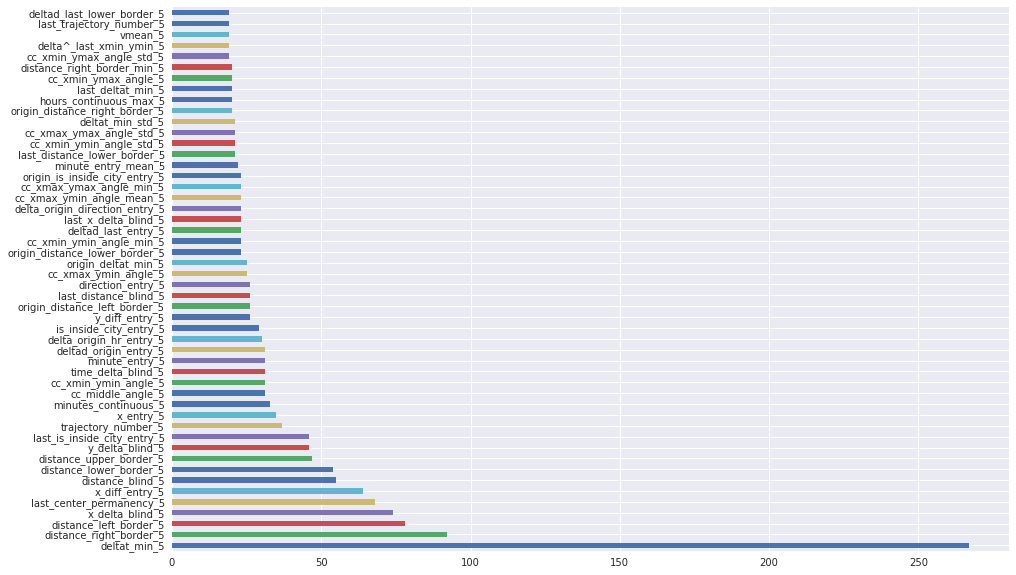

In [71]:
f, ax = plt.subplots(figsize=(15, 10))

feat_importances_gb = pd.Series(clf.feature_importances_, index=data_train[features].columns)
feat_importances_gb.nlargest(50).plot(kind='barh')

In [72]:
data_test = data_sequence[data_sequence.hash.isin(hashs_test)]
#data_test = test[test['x_exit_'+str(window_reference)].isnull()]

In [73]:
data_test.shape

(33515, 1305)

In [74]:
ids = pd.read_csv('../data/raw/data_test.zip', index_col='Unnamed: 0', low_memory=True)
ids = ids[ids.x_exit.isnull()]

In [75]:
data_test = data_test.merge(ids[['hash', 'trajectory_id']], on='hash')

In [76]:
clf.fit(data_train[features], data_train[target])
yhat = clf.predict(data_test[features])

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [77]:
pd.Series(yhat).value_counts()

0.0    24989
1.0     8526
dtype: int64

In [78]:
data_test.head(4)

,hash,vmax_1,vmax_2,vmax_3,vmax_5,vmin_1,vmin_2,vmin_3,vmin_5,vmean_1,...,cc_xmax_ymax_angle_min_5,cc_xmax_ymax_angle_sum_1,cc_xmax_ymax_angle_sum_2,cc_xmax_ymax_angle_sum_3,cc_xmax_ymax_angle_sum_5,count_trajectories_1,count_trajectories_2,count_trajectories_3,count_trajectories_5,trajectory_id
0,00032f51796fd5437b238e3a9823d13d_31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.224386,73.87141,NaN,NaN,58.981582,5.0,NaN,NaN,5.0,traj_00032f51796fd5437b238e3a9823d13d_31_5
1,000479418b5561ab694a2870cc04fd43_25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.899061,NaN,7.750636,NaN,16.472289,NaN,5.0,NaN,5.0,traj_000479418b5561ab694a2870cc04fd43_25_10
2,000506a39775e5bca661ac80e3f466eb_29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.592193,NaN,NaN,25.750249,16.177021,NaN,NaN,4.0,4.0,traj_000506a39775e5bca661ac80e3f466eb_29_5
3,0005401ceddaf27a9b7f0d42ef1fbe95_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.928950,NaN,NaN,NaN,21.513777,NaN,NaN,NaN,1.0,traj_0005401ceddaf27a9b7f0d42ef1fbe95_1_4


In [79]:
submission = pd.DataFrame(list(zip(data_test['trajectory_id'], yhat)), columns=['id', 'target'])

In [81]:
submission.to_csv('../data/submission44_julio.csv', index=False)

# Preprocessed Data Saving

In [84]:
data_sequence.to_hdf('../data/preprocessed/data_sequence_0.89469.hdf', key='deltas', mode='w')